In [1]:
import cv2
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.layers import Lambda, Cropping2D
from keras.models import Model
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
df = pd.read_csv('Data_5\data.csv', header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6
0,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000013
1,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000010
2,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000008
3,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000021
4,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000014


In [4]:
df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']

In [5]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000013
1,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000010
2,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000008
3,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000021
4,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,D:\AI_Workshop_Racing_Team_2023\Preception\Dee...,0.0,0.0,0,0.000014


In [6]:
df.isnull().sum()

center      0
left        0
right       0
steering    0
throttle    0
reverse     0
speed       0
dtype: int64

In [7]:
df.drop(['left', 'right', 'reverse', 'speed'], axis=1, inplace=True)

In [8]:
df.shape

(3930, 3)

<AxesSubplot: ylabel='Frequency'>

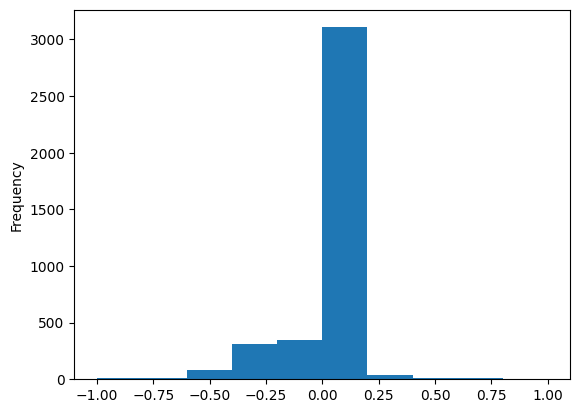

In [9]:
df["steering"].plot(kind='hist')

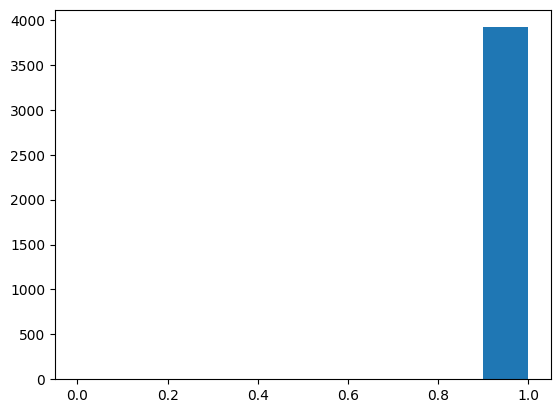

In [10]:
plt.hist(df["throttle"])
plt.show()

In [11]:
# reading the images according to the path in the df data frame 
def read_img(path):
    img = Image.open(path.strip())
    return np.asarray(img)

# reading the center images
df["center"] = df["center"].apply(read_img)

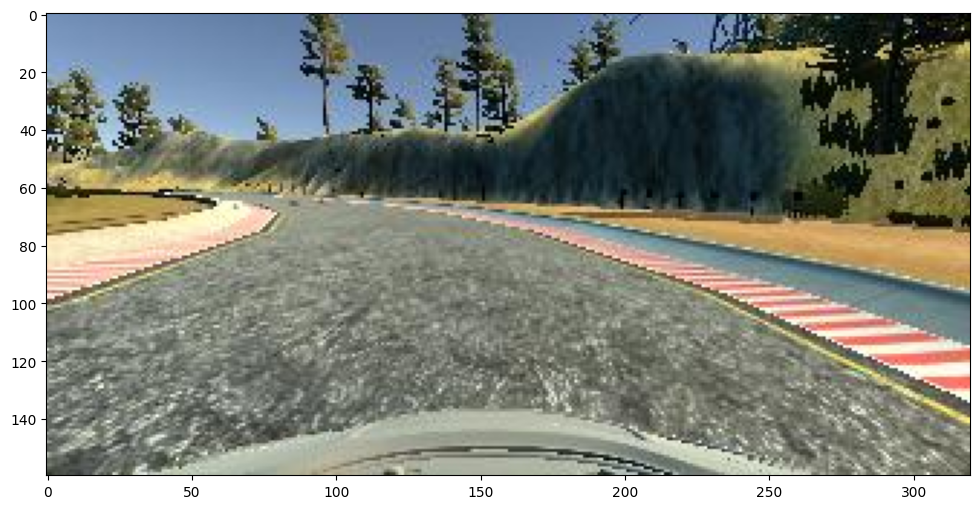

In [12]:
plt.figure(figsize=(16, 6))
plt.imshow(df["center"][0])
plt.show()

In [13]:
def detect_outliers_iqr(dataframe):
    Q1 = dataframe.quantile(0.25)
    Q3 = dataframe.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (dataframe < lower_bound) | (dataframe > upper_bound)

# Example usage
outliers_iqr = detect_outliers_iqr(df[["steering", "throttle"]])

In [14]:
outliers_iqr["steering"].value_counts()

False    3061
True      869
Name: steering, dtype: int64

In [15]:
outliers_iqr["throttle"].value_counts()

False    3919
True       11
Name: throttle, dtype: int64

In [16]:
def remove_outliers_iqr(dataframe):
    Q1 = dataframe.quantile(0.25)
    Q3 = dataframe.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Remove rows with outliers
    cleaned_data = dataframe[~((dataframe < lower_bound) | (dataframe > upper_bound)).any(axis=1)]
    return cleaned_data

test_df=df[["steering", "throttle"]].copy()
# Example usage
cleaned_data_iqr = remove_outliers_iqr(test_df)


In [17]:
cleaned_data_iqr.shape

(3055, 2)

In [18]:
df["steering"].value_counts()

 0.00    3061
-0.15     130
-0.10     121
-0.20      97
-0.05      92
-0.25      91
-0.30      68
-0.35      55
-0.40      31
 0.10      20
-0.45      18
-0.50      17
 0.25      15
 0.30      12
-0.55      12
 0.20      10
 0.15       9
 0.45       8
 0.40       8
 0.05       7
-1.00       6
-0.60       6
 0.60       6
 0.55       5
-0.80       3
 0.35       3
 0.75       3
 0.95       3
-0.70       3
 0.65       2
-0.90       2
-0.65       2
 1.00       1
 0.70       1
-0.75       1
 0.50       1
Name: steering, dtype: int64

In [19]:
# remove 40% of the data with steering angle 0
df = df.drop(df[df["steering"] == 0].sample(frac=0.4).index)

In [20]:
df["steering"].value_counts()

 0.00    1837
-0.15     130
-0.10     121
-0.20      97
-0.05      92
-0.25      91
-0.30      68
-0.35      55
-0.40      31
 0.10      20
-0.45      18
-0.50      17
 0.25      15
 0.30      12
-0.55      12
 0.20      10
 0.15       9
 0.45       8
 0.40       8
 0.05       7
-1.00       6
-0.60       6
 0.60       6
 0.55       5
-0.80       3
 0.35       3
 0.75       3
 0.95       3
-0.70       3
 0.65       2
-0.90       2
-0.65       2
 1.00       1
 0.70       1
-0.75       1
 0.50       1
Name: steering, dtype: int64

In [21]:
df.shape

(2706, 3)

In [22]:
# convert from series to numpy array
center_images_array = np.asarray(df["center"].tolist())
center_images_array.shape

(2706, 160, 320, 3)

In [23]:
num_of_images,rows,columns,channels = center_images_array.shape
num_of_images,rows,columns,channels

(2706, 160, 320, 3)

In [24]:
from sklearn.preprocessing import MinMaxScaler
center_images_reshaped = center_images_array.reshape(-1, channels)
scaler = MinMaxScaler()
center_images_Min_Max = scaler.fit_transform(center_images_reshaped)
print(center_images_Min_Max.shape)
center_images_Min_Max = center_images_Min_Max.reshape(num_of_images, rows, columns, channels)

(138547200, 3)


In [25]:
center_images_Min_Max.shape

(2706, 160, 320, 3)

In [26]:
center_images_Min_Max.shape[0]

2706

In [27]:
for i in range(center_images_Min_Max.shape[0]):
        
    df["center"][i] = center_images_Min_Max[i]


C:\Users\ahmed\AppData\Local\Temp\ipykernel_31724\619708761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["center"][i] = center_images_Min_Max[i]
C:\Users\ahmed\AppData\Local\Temp\ipykernel_31724\619708761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["center"][i] = center_images_Min_Max[i]
C:\Users\ahmed\AppData\Local\Temp\ipykernel_31724\619708761.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["center"][i] =

In [28]:
df["center"]

0       [[[0.4549019607843137, 0.5686274509803921, 0.7...
1       [[[0.4549019607843137, 0.5686274509803921, 0.7...
2       [[[0.4549019607843137, 0.5686274509803921, 0.7...
5       [[[0.4549019607843137, 0.5686274509803921, 0.7...
6       [[[0.4549019607843137, 0.5686274509803921, 0.7...
                              ...                        
3920    [[[112, 140, 179], [112, 140, 179], [111, 139,...
3922    [[[112, 140, 179], [112, 140, 179], [111, 139,...
3925    [[[112, 140, 179], [112, 140, 179], [111, 139,...
3926    [[[112, 140, 179], [112, 140, 179], [111, 139,...
3929    [[[116, 145, 185], [116, 145, 185], [115, 144,...
Name: center, Length: 2706, dtype: object

In [29]:
df.head()

,center,steering,throttle
0,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
1,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
2,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
5,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
6,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",-0.05,0.01613


In [30]:
df.reset_index(drop=True, inplace=True)

In [31]:
data_to_be_splitted = df.copy()
data_to_be_splitted.head()

,center,steering,throttle
0,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
1,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
2,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
3,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",0.00,0.00000
4,"[[[0.4549019607843137, 0.5686274509803921, 0.7...",-0.05,0.01613


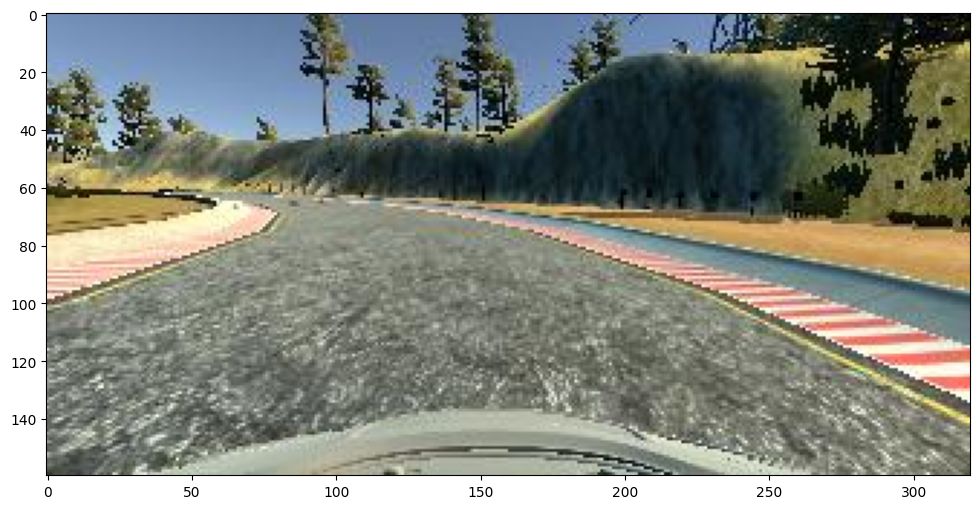

In [32]:
plt.figure(figsize=(16, 6))
plt.imshow(data_to_be_splitted["center"][0])

In [33]:
# Separate the data columns
X = torch.tensor(data_to_be_splitted["center"])  # Input data
y_steering = torch.tensor(data_to_be_splitted["steering"])  # Steering labels
y_throttle = torch.tensor(data_to_be_splitted["throttle"])  # Throttle labels

C:\Users\ahmed\AppData\Local\Temp\ipykernel_31724\1025542473.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X = torch.tensor(data_to_be_splitted["center"])  # Input data


In [34]:
# Split the data into training and testing sets
X_train, X_test, steering_train, steering_test, throttle_train, throttle_test = train_test_split(X, y_steering, y_throttle, test_size=0.2, random_state=42)

In [35]:
class SimpleDeepLearningModel(nn.Module):
    def __init__(self):
        super(SimpleDeepLearningModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3, stride=1)
        self.flatten = nn.Flatten()
        
        
        self.fc_input_size = self.calculate_fc_input_size()
        # Adjusted the input size for the first fully connected layer
        self.fc1 = nn.Linear(self.fc_input_size, 100)  # Adjusted the input size
        
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.steering_output = nn.Linear(10, 1)
        self.throttle_output = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        
        # Adjusted the shape before the first fully connected layer
        x = torch.relu(self.fc1(x.view(x.size(0), -1)))  # Reshape before applying fc1
        
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        steering = self.steering_output(x)
        throttle = self.throttle_output(x)
        return steering, throttle
    
    def calculate_fc_input_size(self):
        # Helper function to calculate the input size for the fully connected layers
        # This function should be called only once after the convolutional layers have been defined
        x = torch.randn(1, 3, 160, 320)  # Create a random input tensor with the same shape as your data
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.view(1, -1).size(1)  # Return the flattened size


In [36]:
# Instantiate the Simple Deep Learning Model
simple_model = SimpleDeepLearningModel()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-3)

In [37]:
# Convert data to numpy arrays
X_train = X_train.numpy()
X_test = X_test.numpy()
steering_train = steering_train.numpy()
steering_test = steering_test.numpy()
throttle_train = throttle_train.numpy()
throttle_test = throttle_test.numpy()

In [38]:
# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
steering_train = torch.tensor(steering_train, dtype=torch.float32)
steering_test = torch.tensor(steering_test, dtype=torch.float32)
throttle_train = torch.tensor(throttle_train, dtype=torch.float32)
throttle_test = torch.tensor(throttle_test, dtype=torch.float32)

In [39]:
# Assuming X_train has shape [32, 3, 160, 320]
# Assuming steering_train and throttle_train are correctly shaped

num_epochs = 10
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, steering_train, throttle_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    simple_model.train()
    for i, (inputs, steering_labels, throttle_labels) in enumerate(train_loader):
        # Ensure the inputs are reshaped to match the model's expected input shape
        inputs = inputs.permute(0, 3, 1, 2)  # Reshape to [32, 3, 160, 320]
        
        # Forward pass
        steering_output, throttle_output = simple_model(inputs)
        steering_loss = criterion(steering_output, steering_labels)
        throttle_loss = criterion(throttle_output, throttle_labels)
        loss = steering_loss + throttle_loss

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.6390085816383362
Epoch 2/10, Loss: 0.2575319707393646
Epoch 3/10, Loss: 0.22863058745861053
Epoch 4/10, Loss: 0.029718562960624695
Epoch 5/10, Loss: 0.024369219318032265
Epoch 6/10, Loss: 0.021732667461037636
Epoch 7/10, Loss: 0.012958378531038761
Epoch 8/10, Loss: 0.054721709340810776
Epoch 9/10, Loss: 0.004770939238369465
Epoch 10/10, Loss: 0.052400827407836914


In [40]:
# Evaluate the models on the test data
def evaluate_model(model, X_test, steering_test, throttle_test):
    model.eval()
    with torch.no_grad():
        steering_output, throttle_output = model(X_test.reshape(-1, 3, 160, 320))
        steering_loss = criterion(steering_output, steering_test)
        throttle_loss = criterion(throttle_output, throttle_test)
        loss = steering_loss + throttle_loss
        print(f"Loss: {loss.item()}")
        return loss.item


In [41]:
# Evaluate the Simple Deep Learning Model
evaluate_model(simple_model, X_test, steering_test, throttle_test)

Loss: 0.022975530475378036


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([542])) that is different to the input size (torch.Size([542, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<function Tensor.item>